# Spotify Popularity Prediction

# Required libraries 


**numpy**: Provides n dimensional arrays to store information

**pandas**: Used to create DataFrames to clearly hold data 
allowing for easy manipulation

**seaborn**: Excellent for quick and easy EDA

**matplotlib**: Basic plotting for EDA 

**sklearn**: Imports necessary machine learning packages for preprocessing, train,test,split as well as model selection and metrics 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
color_pal= [x['color'] for x in plt.rcParams['axes.prop_cycle']]
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('CS98XRegressionTrain.csv')
test = pd.read_csv('CS98XRegressionTest.csv')

# EDA
## Identifying Outliers

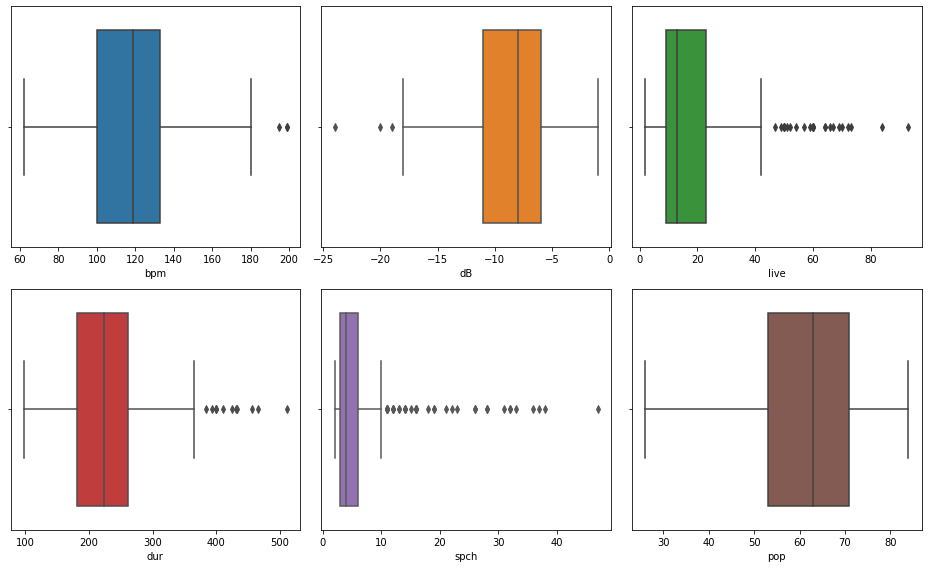

In [3]:
# Take a closer look at these skewed attributes...
numeric_cols = ['bpm', 'dB', 'live', 'dur', 'spch', 'pop']
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
for (ax, col) in zip(axes.flatten(), numeric_cols):
    sns.boxplot(x=col, data=df, color=color_pal[numeric_cols.index(col)] ,ax=ax)
plt.tight_layout()
plt.show()

# Removing Outliers 

* BPM - Dropped anything greater than the max as there were only as few. 
* Db - Dropped anything greater than the max as there were only as few. 
* Dur - Only 12 songs last between 6.4-8.5 minutes and on average they are 40 years old. Initially  all values above 400 minutes were replaced with the upper limit (383.5) calculated using max = q3 + (1.5 * (q3 - q1). Hence, all outliers were dropped for this feature due to the fact they only accounted for 2.66% of the instances. This resulted in a higher correlation between **pop** and **dur**, confirming these data points were adding noise.
* live & spch - The box plot identified that both live and spch had a large number of outliers beyond the upper limit. Doubting their usefulness, correlations between these variables and the target were checked and this verified they were redundant features for prediction.

# Calculating the IQR for Each Feature

In [4]:
# Creating max/min to find cut-off points for dur, bpm, and dB
q1 = df['dur'].quantile(.25)
q3 = df['dur'].quantile(.75)
max = q3 + (1.5 * (q3 - q1))

# Dealing with Outliers

In [5]:
# Dropping Duration outliers
df_drop_dur_outliers = df[(df['dur']> 383.5)].index
df = df.drop(df_drop_dur_outliers, axis=0)

# Dropping bpm outliers 
df_drop__bpm_outliers = df[(df['bpm']> 182.5)].index
df = df.drop(df_drop__bpm_outliers, axis=0)

# Dropping dB outliers
df_drop_dB = df[(df['dB']< -18.5)].index
df = df.drop(df_drop_dB, axis=0)

# Feature Engineering - New Features

The feature engineering included several attempts to create new features that would strongly correlate positively or negatively with **pop**.

Dur/Per_BPM showed the most promise accross Pearson, Spearman and Kendall coefficients averaging 30.35% with popularity. Despite its promise, this new feature was dropped and the original features were kept individually as dur on its own still truimphed over this new feaure by around 18%. Furthermore, nrgy, val and dance were combined on the assumption that each of these features were measuring slight variations of a similar concept. However this combined feature resulted in an average 14.99% correlation with popularity. Therefore, the new feature was dropped and not considered to be of great value.



# Potential Useful Feature Prolific

The columns `prolific` and `common_genre` were created as a way to distinguish popular songs from less popular songs on the assumptions that artists with more songs in the set and genres which are more prevelent in the set  might be more popular, respectively.

In [6]:
big_artists = ["Elton John", "ABBA", "Queen", "The Beatles", 'Rihanna',
               'Whitney Houston', 'Mariah Carey', 'Taylor Swift']
               
common_genres = ['adult standards', 'album rock', 'dance pop',
                 'brill building pop', 'glam rock', 'europop',
                 'dance rock', 'boy band']
prolific = []

for artist in df['artist']:
    if artist in big_artists:
        prolific.append(1)
    else:
        prolific.append(0)

df.insert(3, column = 'prolific', value = np.array(prolific))

common_genre = []

for genre in df['top genre']:
    if genre in common_genres:
        common_genre.append(1)
    else:
        common_genre.append(0)

df.insert(5, column = 'common_genre', value = np.array(common_genre))

# pop_notprolific & pop_prolific
pop_notprolific = df[df['prolific']==0]['pop'].mean()
pop_prolific = df[df['prolific']==1]['pop'].mean()
print(f'The average popularity of non-prolific artists is {pop_notprolific}, as opposed to {pop_prolific} for prolific artists.')

# uncommon & common
uncommon = df[df['common_genre']==0]['pop'].mean()
common = df[df['common_genre']==1]['pop'].mean()
print(f'The average popularity of non-common genres is {uncommon}, as opposed to {common} for common genres.')

The average popularity of non-prolific artists is 59.94102564102564, as opposed to 70.25531914893617 for prolific artists.
The average popularity of non-common genres is 58.94915254237288, as opposed to 62.48076923076923 for common genres.


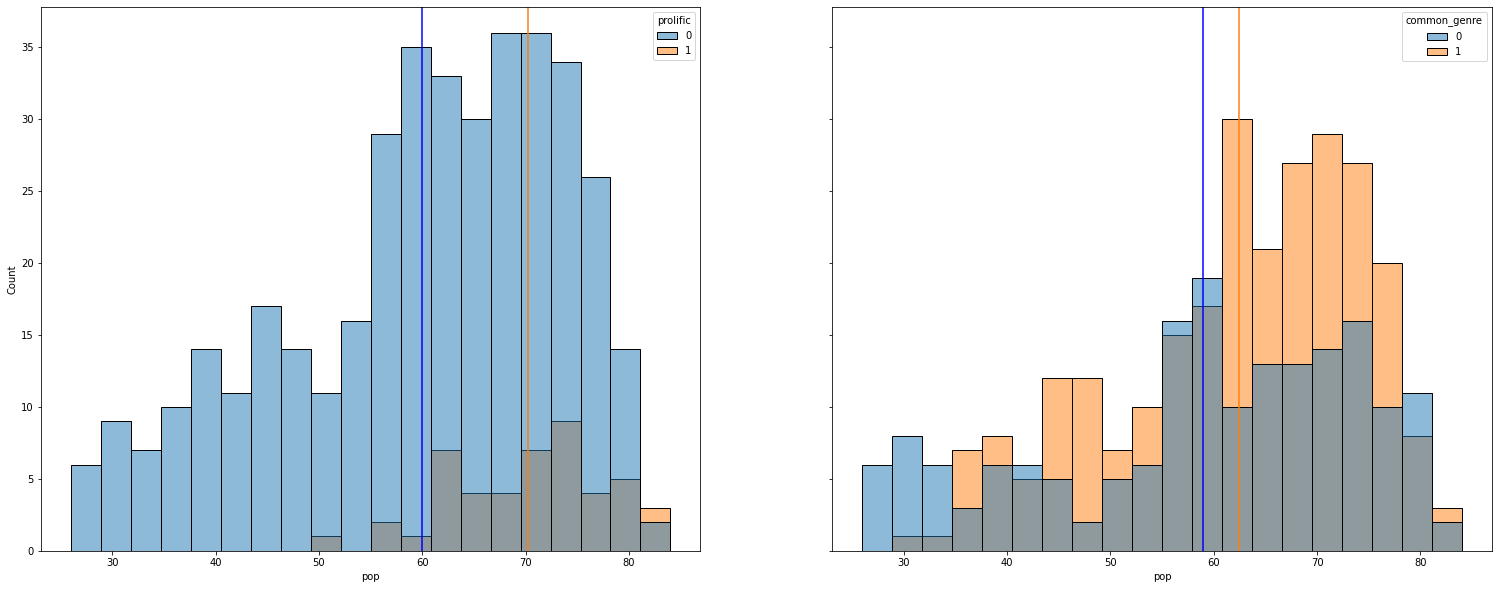

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (26,10), sharey = True)
sns.histplot(data=df, x="pop", bins = 20, ax=ax1, hue='prolific')
ax1.axvline(x=pop_notprolific, color='b')
ax1.axvline(x=pop_prolific, color='#ff7f0e')
sns.histplot(data=df, x="pop", bins = 20, ax=ax2, hue='common_genre')
ax2.axvline(x=uncommon, color='b')
ax2.axvline(x=common, color='#ff7f0e')

The difference in **pop** between aritsts (left) with < 4 songs in the dataset (prolific = 0) and artists with 4 or more songs (prolific = 1) is arguably significant , with a difference of ~10 in mean **pop** score between the two groups. Artists with 4 or more songs appear to be slightly more popular than those who do not and also have fewer unpopular songs. As the inclusion of this feature led to better model performace on the validation set, it was retained.
  
The same cannot be argued for common vs uncommon genres, since the mean popularity for these groups are closer and there is no relevant difference between the distributions of these two groups. As expected, this was not a useful predictor of **pop** and so it was dropped.

In [8]:
big_artists = ["Elton John", "ABBA", "Queen", "The Beatles", 'Rihanna',
               'Whitney Houston', 'Mariah Carey', 'Taylor Swift']
prolific = []

for artist in test['artist']:
    if artist in big_artists:
        prolific.append(1)
    else:
        prolific.append(0)

test.insert(3, column = 'prolific', value = np.array(prolific))

# Feature Correlations

As revealed by the below DataFrame of correlation values between the target and its predictors, some features appear to be promising while others are unlikely to yield better performance. The inclusion of these features during experimentation with various models verified some features were not useful, and so are dropped prior to training the models.

In [9]:
pearson_corr = df.corr()["pop"] # Pearson is default
spearman_corr = df.corr(method='spearman')["pop"]
kendall_corr = df.corr(method='kendall')["pop"]
corr_df = pd.DataFrame({'Pearson': pearson_corr, 'Spearman': spearman_corr, 'Kendall': kendall_corr})
corr_df.sort_values(by='Pearson', ascending=False)

,Pearson,Spearman,Kendall
pop,1.000000,1.000000,1.000000
dur,0.477781,0.433817,0.301031
dB,0.306084,0.284101,0.202737
nrgy,0.304533,0.227323,0.149729
dnce,0.250043,0.231540,0.160027
prolific,0.239054,0.247023,0.204114
spch,0.148519,0.130540,0.096755
common_genre,0.129695,0.099676,0.082362
Id,0.089578,0.088095,0.058879
bpm,0.070071,0.037376,0.026091


# Year Feature

Looking at how **pop** varies over time, the year variables seemed unlikely to be a good predictor in its original form, but a reduction of granularity was achieved by allocating songs into 5-year time windows. As this resulted in slightly better model performance, this new feature was retained and one-hot encoded for model training.

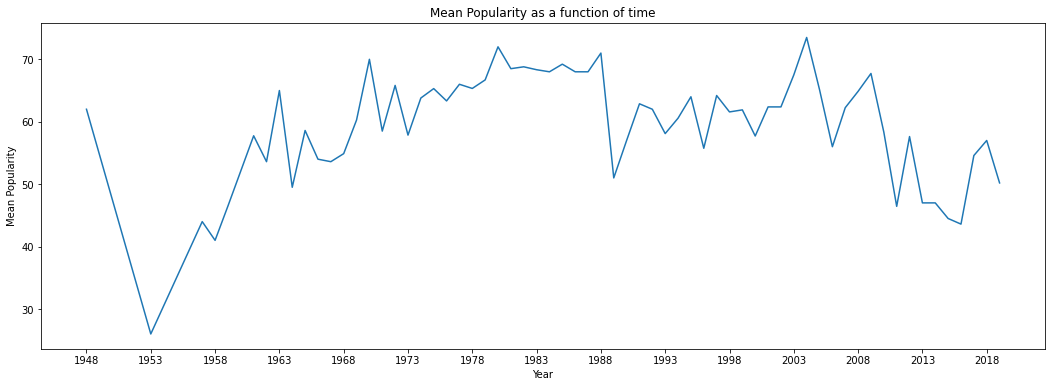

In [10]:
# How does pop vary with time?
fig, ax = plt.subplots(figsize=(18, 6))
ax = df.groupby('year')['pop'].mean().plot()
ax.set_title('Mean Popularity as a function of time')
ax.set_ylabel('Mean Popularity')
ax.set_xlabel('Year')
ax.set_xticks(range(1948, 2019, 5))
plt.show()

# One-Hot Encoding Year

In [11]:
def year_dummies_per5yrs(df):
    df['Dummies_Yr'] = 0 
    df['Dummies_Yr'] = np.where(((df['year'] >= 1945) & (df['year'] < 1950)), '1945-1950', df['Dummies_Yr'])
    df['Dummies_Yr'] = np.where(((df['year'] >= 1950) & (df['year'] < 1955)), '1950-1955', df['Dummies_Yr'])
    df['Dummies_Yr'] = np.where(((df['year'] >= 1955) & (df['year'] < 1960)), '1955-1960', df['Dummies_Yr'])
    df['Dummies_Yr'] = np.where(((df['year'] >= 1960) & (df['year'] < 1965)), '1960-1965', df['Dummies_Yr'])
    df['Dummies_Yr'] = np.where(((df['year'] >= 1965) & (df['year'] < 1970)), '1965-1970', df['Dummies_Yr'])
    df['Dummies_Yr'] = np.where(((df['year'] >= 1970) & (df['year'] < 1975)), '1970-1975', df['Dummies_Yr'])
    df['Dummies_Yr'] = np.where(((df['year'] >= 1975) & (df['year'] < 1980)), '1975-1980', df['Dummies_Yr'])
    df['Dummies_Yr'] = np.where(((df['year'] >= 1980) & (df['year'] < 1985)), '1980-1985', df['Dummies_Yr'])
    df['Dummies_Yr'] = np.where(((df['year'] >= 1985) & (df['year'] < 1990)), '1985-1990', df['Dummies_Yr'])
    df['Dummies_Yr'] = np.where(((df['year'] >= 1990) & (df['year'] < 1995)), '1990-1995', df['Dummies_Yr'])
    df['Dummies_Yr'] = np.where(((df['year'] >= 1995) & (df['year'] < 2000)), '1995-2000', df['Dummies_Yr'])
    df['Dummies_Yr'] = np.where(((df['year'] >= 2000) & (df['year'] < 2005)), '2000-2005', df['Dummies_Yr'])
    df['Dummies_Yr'] = np.where(((df['year'] >= 2005) & (df['year'] < 2010)), '2005-2010', df['Dummies_Yr'])
    df['Dummies_Yr'] = np.where(((df['year'] >= 2010) & (df['year'] < 2015)), '2010-2015', df['Dummies_Yr'])
    df['Dummies_Yr'] = np.where(((df['year'] >= 2015) & (df['year'] < 2020)), '2015-2020', df['Dummies_Yr'])

    return df

In [12]:
df = pd.DataFrame(year_dummies_per5yrs(df))

In [13]:
from sklearn.preprocessing import OneHotEncoder

# OneHotEncoding
cat_encoder = OneHotEncoder(sparse=False)
genre_cat_1hot = cat_encoder.fit_transform(df[['Dummies_Yr']])
enc_data = pd.DataFrame(genre_cat_1hot)
enc_data.columns = cat_encoder.categories_[0]
enc_data.index = df.index
# drop last column
enc_data = enc_data.drop(['2015-2020'], axis=1).copy()
encoded_df = pd.concat([df, enc_data], axis =1, ignore_index = False)
encoded_df = encoded_df.drop(['Dummies_Yr'], axis=1).copy()

In [14]:
test = pd.DataFrame(year_dummies_per5yrs(test))

ohe_test = cat_encoder.transform(test[['Dummies_Yr']])
enc_data_test = pd.DataFrame(ohe_test)
enc_data_test.columns = cat_encoder.categories_[0]
enc_data_test.index = test.index
# drop last column
enc_data_test = enc_data_test.drop(['2015-2020'], axis=1).copy()
encoded_test = pd.concat([test, enc_data_test], axis =1, ignore_index = False)
encoded_test = encoded_test.drop(['Dummies_Yr'], axis=1).copy()

# Dropping Redundant Features 

In [15]:
train = encoded_df.drop(labels=['Id', 'title', 'artist','top genre' ,'year', 'spch', 'live', 'common_genre'], axis=1)
test = encoded_test.drop(labels=['Id', 'title', 'artist','top genre' ,'year', 'spch', 'live'], axis=1)

In [16]:
X = train.drop('pop', axis=1)
y = train['pop']

# Train, Test, Split 

In [17]:
# Set seed for consistency across runs
seed = 1
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=seed)

# Notes on Modelling
### Experimentation

The penultimate stage of fitting and evaluating various candidate models was an iterative process of determining which models would best perform the task, and discovering which feature selection, transformation & engineering combinations lead to the best perfomance consistently - as determined through cross-validation and testing with a validation set. The purpose of this was to eliminate under-perfoming models and omit data preparation decisions, which would not be worthwhile exploring during model ensembling and optimisation.

For this task a variety of non-linear models were imported from scikit-learn, including K-Nearest Neighbours Regressor, a Support Vector Regressor, a Decision Tree, and a convenient ensemble of this model - the Extra Trees Regressor. They were chosen to introduce a diversity of models with regards to the algorithms they use and their inherent bias. For example, the KNN Regressor introduces a model for instance-based learning unlike the other model-based learners used and the Extra Trees model was used to introduce more bias at the expense of variance in comparison to the simple Decision Tree. Linear models were excluded from consideration due to the dearth of linear relationships and non-Gaussian distributions in the data which would violate the core assumptions of linear models.

The Decision Tree (DT) was found to consistently underperform in comparison to other models, though the KNN regressor was only slightly better. The group concluded the complex relationship between the target feature and it's predictors, combined with the few training instances, presented too great a challenge for these relatively simple models. Although the KNN regressor did see improvement by increasing the number of neighbours used in the prediction, making it more resillient to outliers. After settling on a set of data processing/feature selection steps that provided the best performance on simpler models, GridSearchCV was used to optimise these models before carrying a selection of them forward to the processes of ensembling.

# Cross-valiate, Run model and display score functions 

In [18]:
cv = 4

# Displays scores 
def display_scores(scores):
  print("RMSE:", scores)
  print("Mean RMSE:", scores.mean())
  print("Std_dev:", scores.std())   

# Cross validation summary with cv =4 
def cross_val_summary(trained_model, input_vars, target):
    model_mse =  cross_val_score(trained_model, input_vars, target,
                             scoring="neg_mean_squared_error", cv=cv)
    model_rmse = np.sqrt(-model_mse)
    display_scores(model_rmse)

# runs models to fit and predict
def run_model(model,X_train,y_train,X_val,y_val):
    # Fit Model
    model.fit(X_train,y_train)
    # Get Metrics
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val,preds))
    print(f'RMSE on validation: {rmse}')    

# Scaling

In [19]:
# caling the training set  
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_scaled = scaler.transform(test)

In [20]:
# Import models and other necessary functions
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

# KNeighbors Regressor

In [ ]:
param_grid = [{'n_neighbors': list(range(2, 10)), 'weights' : ['uniform', 'distance']}]
knn = KNeighborsRegressor()
grid_search_knn = GridSearchCV(knn, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid_search_knn.fit(X_train, y_train)
print(grid_search_knn.best_params_)

In [22]:
knn = grid_search_knn.best_estimator_
run_model(knn,X_train,y_train,X_val,y_val)
print('---------')
cross_val_summary(knn, X_train, y_train)

RMSE on validation: 9.454943055913818
---------
RMSE: [11.8935005  12.09151369 10.29300785 10.81739802]
Mean RMSE: 11.27385501750403
Std_dev: 0.7454764236378024


# Decision Tree Regressor 

In [ ]:
param_grid = {"min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": list(range(2, 100, 10)),
              }

DTR = DecisionTreeRegressor()
gridsearch_dt = GridSearchCV(DTR, param_grid, cv=cv, scoring='neg_mean_squared_error')
gridsearch_dt.fit(X_train, y_train)
gridsearch_dt.best_params_

In [24]:
DTR = gridsearch_dt.best_estimator_
run_model(DTR,X_train,y_train,X_val,y_val)
print('----------')
cross_val_summary(DTR, X_train, y_train)

RMSE on validation: 10.759691404946588
----------
RMSE: [12.02070804 12.32360131 10.36202306 11.28742691]
Mean RMSE: 11.498439831214782
Std_dev: 0.7565753557039654


# SVR

In [ ]:
param_grid = {"kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
              "degree": [2, 3, 5, 10],
              "C": [0.001, 0.1, 1, 10, 100],
              "epsilon": [0.001, 0.1, 1, 10],
              }
gridsearch_svr = GridSearchCV(SVR(), param_grid, verbose=1, cv=cv, scoring='neg_mean_squared_error')
gridsearch_svr.fit(X_train, y_train)
gridsearch_svr.best_params_

In [27]:
svr = gridsearch_svr.best_estimator_
run_model(svr,X_train,y_train,X_val,y_val)
print('----------')
cross_val_summary(svr, X_train, y_train)

RMSE on validation: 9.641774784137258
----------
RMSE: [11.98739669 11.88105097  9.08916519 10.75540999]
Mean RMSE: 10.928255708833104
Std_dev: 1.1663755819027393


# Extra Decision Tree Regressor 

In [ ]:
param_grid = [{'n_estimators': [50, 100, 200], 
               'max_depth': [3, 10, 50],
               'max_features': ['auto', 'log2'], 
               'bootstrap': [True, False],
               'min_samples_leaf': [2,3,4]}]

ExtrReg = ExtraTreesRegressor()
grid_search_etrf = GridSearchCV(ExtrReg, param_grid, cv=cv, scoring='neg_mean_squared_error')
grid_search_etrf.fit(X_train, y_train)
grid_search_etrf.best_params_

In [29]:
ExtrReg = grid_search_etrf.best_estimator_
run_model(ExtrReg,X_train,y_train,X_val,y_val)
print('----------')
cross_val_summary(ExtrReg, X_train, y_train)

RMSE on validation: 9.122629341560367
----------
RMSE: [11.77720388 12.13626341  9.25096668 11.41034899]
Mean RMSE: 11.143695741197018
Std_dev: 1.1225028279459863


# Ensembles

With data already prepared and promising base models identified, the group could be slightly more liberal in the application of ensembles to identify the best model. This meant applying bagging/pasting and boosting - using GridSearchCV to identfiy the optimised model hyperparameters. The validation set performed better with Gradient Boosting than with Extreme Gradient Boosting - an admittidly unexpected finding given it typically performs better than standard Gradient Boosting. The latter of these models was hence dropped from consideration.

It was found that Bagging and Pasting approaches yielded comparable performance to one another, and although they were typically underperforming the Extra Trees model they enhanced the performance of our final and best performing model - a Voting Regressor. The intention was to use models which showed stong performance on the validation set and include those models which differed considerably in the algorithms applied - hence the best Voting Regressor achieved containts exactly this.

# Gradient Boosting Regressor 

In [ ]:
param_grid = {"n_estimators": [50, 100, 300],
              "learning_rate": [0.01, 0.1],
              "max_depth": [3, 5, 10],
              "max_features": ['auto', 'log2'],
}
gbrt = GradientBoostingRegressor()
gridsearch_gbrt = GridSearchCV(gbrt, param_grid, cv=cv, scoring='neg_mean_squared_error')
gridsearch_gbrt.fit(X_train, y_train)
gridsearch_gbrt.best_params_

In [31]:
gbrt = gridsearch_gbrt.best_estimator_
run_model(gbrt,X_train,y_train,X_val,y_val)
print('----------')
cross_val_summary(gbrt, X_train, y_train)

RMSE on validation: 9.700001340334781
----------
RMSE: [12.0126364  11.9844501   9.09708215 10.98756489]
Mean RMSE: 11.020433384900588
Std_dev: 1.1847104475445989


# Bagging/Pasting Regressor

In [ ]:
param_grid = {"n_estimators": [10, 50, 100],
              "max_samples": [0.67, 0.75, 1.0],
              "max_features": [0.67, 0.75, 1.0],
              "bootstrap": [True, False],
              }
bag_reg = BaggingRegressor(KNeighborsRegressor(n_neighbors=9, weights='distance'), n_jobs=-1)
gridsearch_bag = GridSearchCV(bag_reg, param_grid, cv=cv, scoring='neg_mean_squared_error')
gridsearch_bag.fit(X_train, y_train)
gridsearch_bag.best_params_

In [33]:
BagReg = gridsearch_bag.best_estimator_
run_model(BagReg,X_train,y_train,X_val,y_val)
print('----------')
cross_val_summary(BagReg, X_train, y_train)

RMSE on validation: 9.339223576288447
----------
RMSE: [12.39455538 12.01004591  9.53062249 10.93240359]
Mean RMSE: 11.21690684271369
Std_dev: 1.111353078302545




---


# Voting Regressor - Final Model

In [34]:
voting_reg = VotingRegressor(estimators=[('knn', knn), ('svr', svr), ('rf', ExtrReg), ('bag', BagReg), ('gradb', gbrt)])
run_model(voting_reg,X_train,y_train,X_val,y_val)
print('----------')
cross_val_summary(voting_reg, X_train, y_train)

RMSE on validation: 9.11879155454733
----------
RMSE: [11.75241291 11.76387618  9.07155557 10.71277988]
Mean RMSE: 10.825156136348397
Std_dev: 1.098720142214767




---

---



# Model Performance

Interestingly, all models appear to perform slightly worse during cross validation of the training data than they do on the validation set. Taking a closer look, it appears each model performs better on one of the 4 folds than the others, and this is the same fold for each model. This might suggest that the training data may still contain some noise that was not identified during the EDA, distorting the relationship between popularity and the other features. On the other hand, both the 25% used for one of the folds and the validation set may then have less noise, allowing for stonger performance on these sets. This is also a reassuring indicator that the models created are resilient to this noise, as they are not overfitting to the training data.

As seen above, the final models achieve similar perfomance on the validation set with the exception of the DecisionTreeRegressor which tends to have a significantly higher RMSE. Across many runs, the VotingRegressor achieves an RMSE between 9.10 and 9.25, averaging around 9.17, while its best performance on the test set is slighly lower at 8.97.

The expectation was that the model would perform slightly worse on the test data than training data, but the converse it true here. One explanation for this outcome is simply that 8.97 was the model's *best* performance on the test data, while previous runs resulted in slightly worse performance - hence, it's  more likely the model performs equally well across all unseen data at best, if not slightly worse.

Finally, while the Voting Regressor's performance is very similar to that of our optimised Extra Trees Regressor and Bagging Regressor with respect to RMSE; its lower standard deviation across folds of the training data suggested it would perform better across unseen data, so the Voting Regressor became the final model.

In [36]:
# Test on validation set
for reg in (knn, svr, DTR, ExtrReg, BagReg, gbrt, voting_reg):
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    print(reg.__class__.__name__, "=", np.sqrt(mean_squared_error(y_val, y_pred)))

KNeighborsRegressor = 9.454943055913818
SVR = 9.641774784137258
DecisionTreeRegressor = 10.759691404946588
ExtraTreesRegressor = 9.174652518526514
BaggingRegressor = 9.160801715343679
GradientBoostingRegressor = 9.732568515094746
VotingRegressor = 9.123698801428615


In [37]:
# Predictions on test data
predictions = voting_reg.predict(test_scaled)

pd.DataFrame(predictions).set_index(encoded_test['Id']).rename(columns={0:'pop'}).to_csv('upload.csv')